In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.options.mode.chained_assignment = None

In [3]:
# Reading Dataset
df = pd.read_csv('country.csv')
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
# Determining categoric, cardinal and numeric columns according to given threshold.
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if
                dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if
                   dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if
                dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 167
Variables: 10
cat_cols: 0
num_cols: 9
cat_but_car: 1
num_but_cat: 0


In [5]:
# Outliers
# Determining low and up limit according to given quantile values.
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
# Outliers check.
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) |
                 (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
# Changing outlier variables given threshold values.
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), 
                  variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), 
                  variable] = up_limit
for col in num_cols:
    print(col, check_outlier(df, col))

child_mort False
exports True
health False
imports False
income True
inflation True
life_expec False
total_fer False
gdpp False


In [6]:
for col in num_cols:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)
for col in num_cols:
    print(col, check_outlier(df, col))

child_mort False
exports True
health False
imports False
income True
inflation True
life_expec False
total_fer False
gdpp False
child_mort False
exports False
health False
imports False
income False
inflation False
life_expec False
total_fer False
gdpp False


In [7]:
# Missing Values
# Querying missing values.
df.isnull().any()

country       False
child_mort    False
exports       False
health        False
imports       False
income        False
inflation     False
life_expec    False
total_fer     False
gdpp          False
dtype: bool

In [8]:
# Scaling
# Scaling numerical columns so that they do not dominate.
df_scaled = df[["child_mort","exports","health","imports","income",
                "inflation","life_expec","total_fer","gdpp"]]
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_scaled)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = ["child_mort","exports","health","imports",
                     "income","inflation","life_expec",
                     "total_fer","gdpp"]
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.158276,0.279088,-0.082455,-0.814829,0.240348,-1.619092,1.902882,-0.679180
1,-0.538949,-0.485916,-0.097016,0.070837,-0.377399,-0.363528,0.647866,-0.859973,-0.485623
2,-0.272833,-0.097442,-0.966073,-0.641762,-0.221249,1.052835,0.670423,-0.038404,-0.465376
3,2.007808,0.795303,-1.448071,-0.165315,-0.589279,1.821403,-1.179234,2.128151,-0.516268
4,-0.695634,0.167767,-0.286894,0.497568,0.104721,-0.735612,0.704258,-0.541946,-0.041817


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


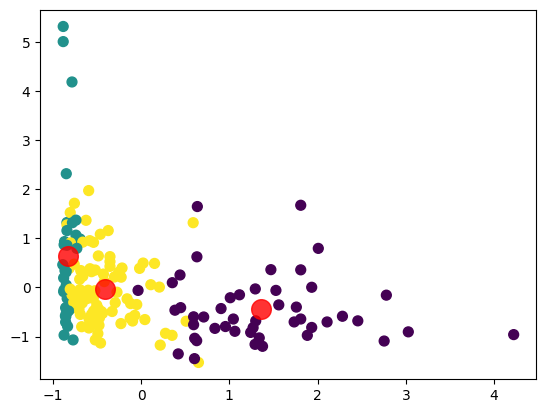

In [9]:
# K-Means Clustering Method
# Creating first model with random cluster number which is 3 and fitting last dataframe.
kmeans = KMeans(n_clusters=3)
k_fit = kmeans.fit(df_scaled)

# n_clusters: give cluster number in the model.
# cluster_centers_: give center of each clusters.
# labels_: give labels of each point.
# inertia_: give sum of squared distances (SSD) of samples to their closest cluster center.
# Visualizing of model.
clusters = k_fit.labels_
centers = k_fit.cluster_centers_

plt.scatter(df_scaled.iloc[:, 0],
            df_scaled.iloc[:, 1],
            c=clusters,
            s=50,
            cmap="viridis")

plt.scatter(centers[:, 0],
            centers[:, 1],
            c="red",
            s=200,
            alpha=0.8)
plt.show()

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

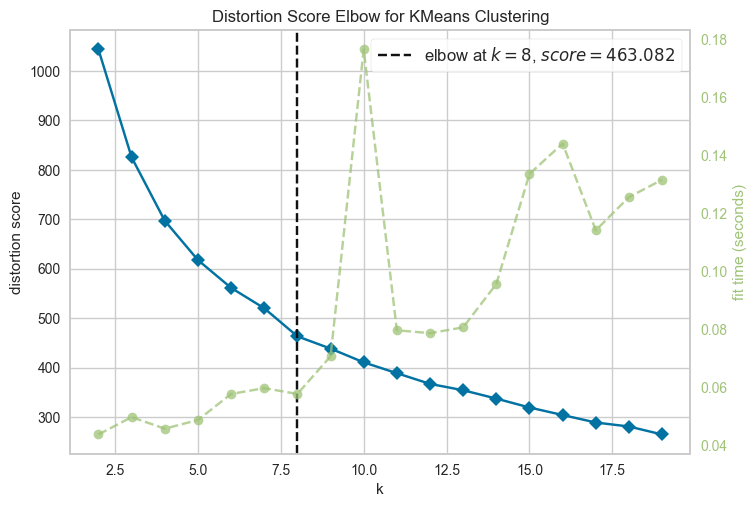

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
# Finding optimal cluster number by using Elbow method.
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2,20))
elbow.fit(df_scaled)
elbow.show()

In [13]:
# Final Model with Optimum k cluster.
kmeans = KMeans(n_clusters=elbow.elbow_value_)
kmeans = kmeans.fit(df_scaled)

df_scaled.loc[:,'country'] = df['country']

df_scaled['cluster'] = kmeans.labels_
df_scaled['cluster'] = df_scaled['cluster'] + 1
df_scaled['cluster'].unique()

# Inverse scaling for each numerical columns.
df_scaled[["child_mort","exports","health","imports","income",
           "inflation","life_expec","total_fer","gdpp"]] \
    = scaler.inverse_transform(df_scaled[["child_mort","exports",
                                          "health","imports",
                                          "income","inflation",
                                          "life_expec","total_fer",
                                          "gdpp"]])
final_df = df_scaled
final_df.head()

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,country,cluster
0,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553.0,Afghanistan,3
1,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090.0,Albania,2
2,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460.0,Algeria,2
3,119.0,62.3,2.85,42.9,5900.0,22.40,60.1,6.16,3530.0,Angola,3
4,10.3,45.5,6.03,58.9,19100.0,1.44,76.8,2.13,12200.0,Antigua and Barbuda,1


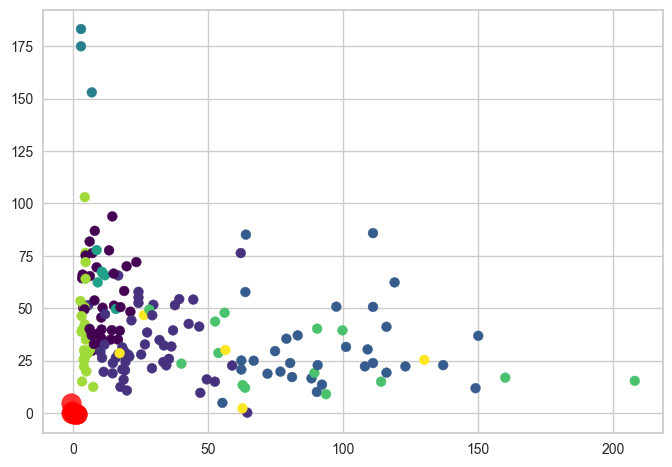

In [14]:
# Visualizing Clusters

clusters = kmeans.labels_
centers = kmeans.cluster_centers_

plt.scatter(final_df.iloc[:, 0],
            final_df.iloc[:, 1],
            c=clusters,
            s=50,
            cmap="viridis")

plt.scatter(centers[:, 0],
            centers[:, 1],
            c="red",
            s=200,
            alpha=0.8)
plt.show()